In [23]:
import pandas as pd
import numpy as np
import scipy.stats as st
from scipy.stats import linregress
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect
from flask import Flask, jsonify
import json

In [24]:
path = "sqlite:///Resources/hawaii.sqlite"
engine = create_engine(path)
conn= engine.connect()

In [25]:
inspector = inspect(engine)

tables = inspector.get_table_names()
tables

['measurement', 'station']

In [26]:
for table in tables:
    columns = inspector.get_columns(table)
    print(table)
    print()
    for column in columns:
        print(column["name"], column["type"])
    
    # or put it as a dataframe
    display(pd.DataFrame(columns))
    
    print()

measurement

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


,name,type,nullable,default,autoincrement,primary_key
0,id,INTEGER,False,None,auto,1
1,station,TEXT,True,None,auto,0
2,date,TEXT,True,None,auto,0
3,prcp,FLOAT,True,None,auto,0
4,tobs,FLOAT,True,None,auto,0



station

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


,name,type,nullable,default,autoincrement,primary_key
0,id,INTEGER,False,None,auto,1
1,station,TEXT,True,None,auto,0
2,name,TEXT,True,None,auto,0
3,latitude,FLOAT,True,None,auto,0
4,longitude,FLOAT,True,None,auto,0
5,elevation,FLOAT,True,None,auto,0


In [27]:
query= """
    SELECT
        *
    FROM
        station
    """

station_df = pd.read_sql(query, conn)

station_df.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [28]:
query= """
    SELECT
        *
    FROM
        measurement
    """

measurement_df = pd.read_sql(query, conn)

measurement_df.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


Percipitation Analysis

In [29]:
# Find the most recent date in the data set.
query= """
    SELECT
        max(date)
    FROM
        measurement
    """
engine.execute(query).fetchall()

[('2017-08-23',)]

In [30]:
#the last 12 months of precipitation data by querying the 12 preceding months of data.
query= """
    SELECT
        *
    FROM
        measurement
    WHERE
        date >= '2016-08-23';
    """
lastyear_df = pd.read_sql(query, conn)

lastyear_df.head()

,id,station,date,prcp,tobs
0,2364,USC00519397,2016-08-23,0.00,81.0
1,2365,USC00519397,2016-08-24,0.08,79.0
2,2366,USC00519397,2016-08-25,0.08,80.0
3,2367,USC00519397,2016-08-26,0.00,79.0
4,2368,USC00519397,2016-08-27,0.00,77.0


In [31]:
lastyear_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2230 entries, 0 to 2229
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       2230 non-null   int64  
 1   station  2230 non-null   object 
 2   date     2230 non-null   object 
 3   prcp     2021 non-null   float64
 4   tobs     2230 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 87.2+ KB


In [32]:
#Select only the date and prcp values.
df= lastyear_df[["date", "prcp"]]
df.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [33]:
#Sort the DataFrame values by date
df= df.sort_values(by=['date']).reset_index(drop=True)
df.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-23,NaN
2,2016-08-23,1.79
3,2016-08-23,0.05
4,2016-08-23,0.15


In [34]:
df["date"] = pd.to_datetime(df["date"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2230 entries, 0 to 2229
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2230 non-null   datetime64[ns]
 1   prcp    2021 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 35.0 KB


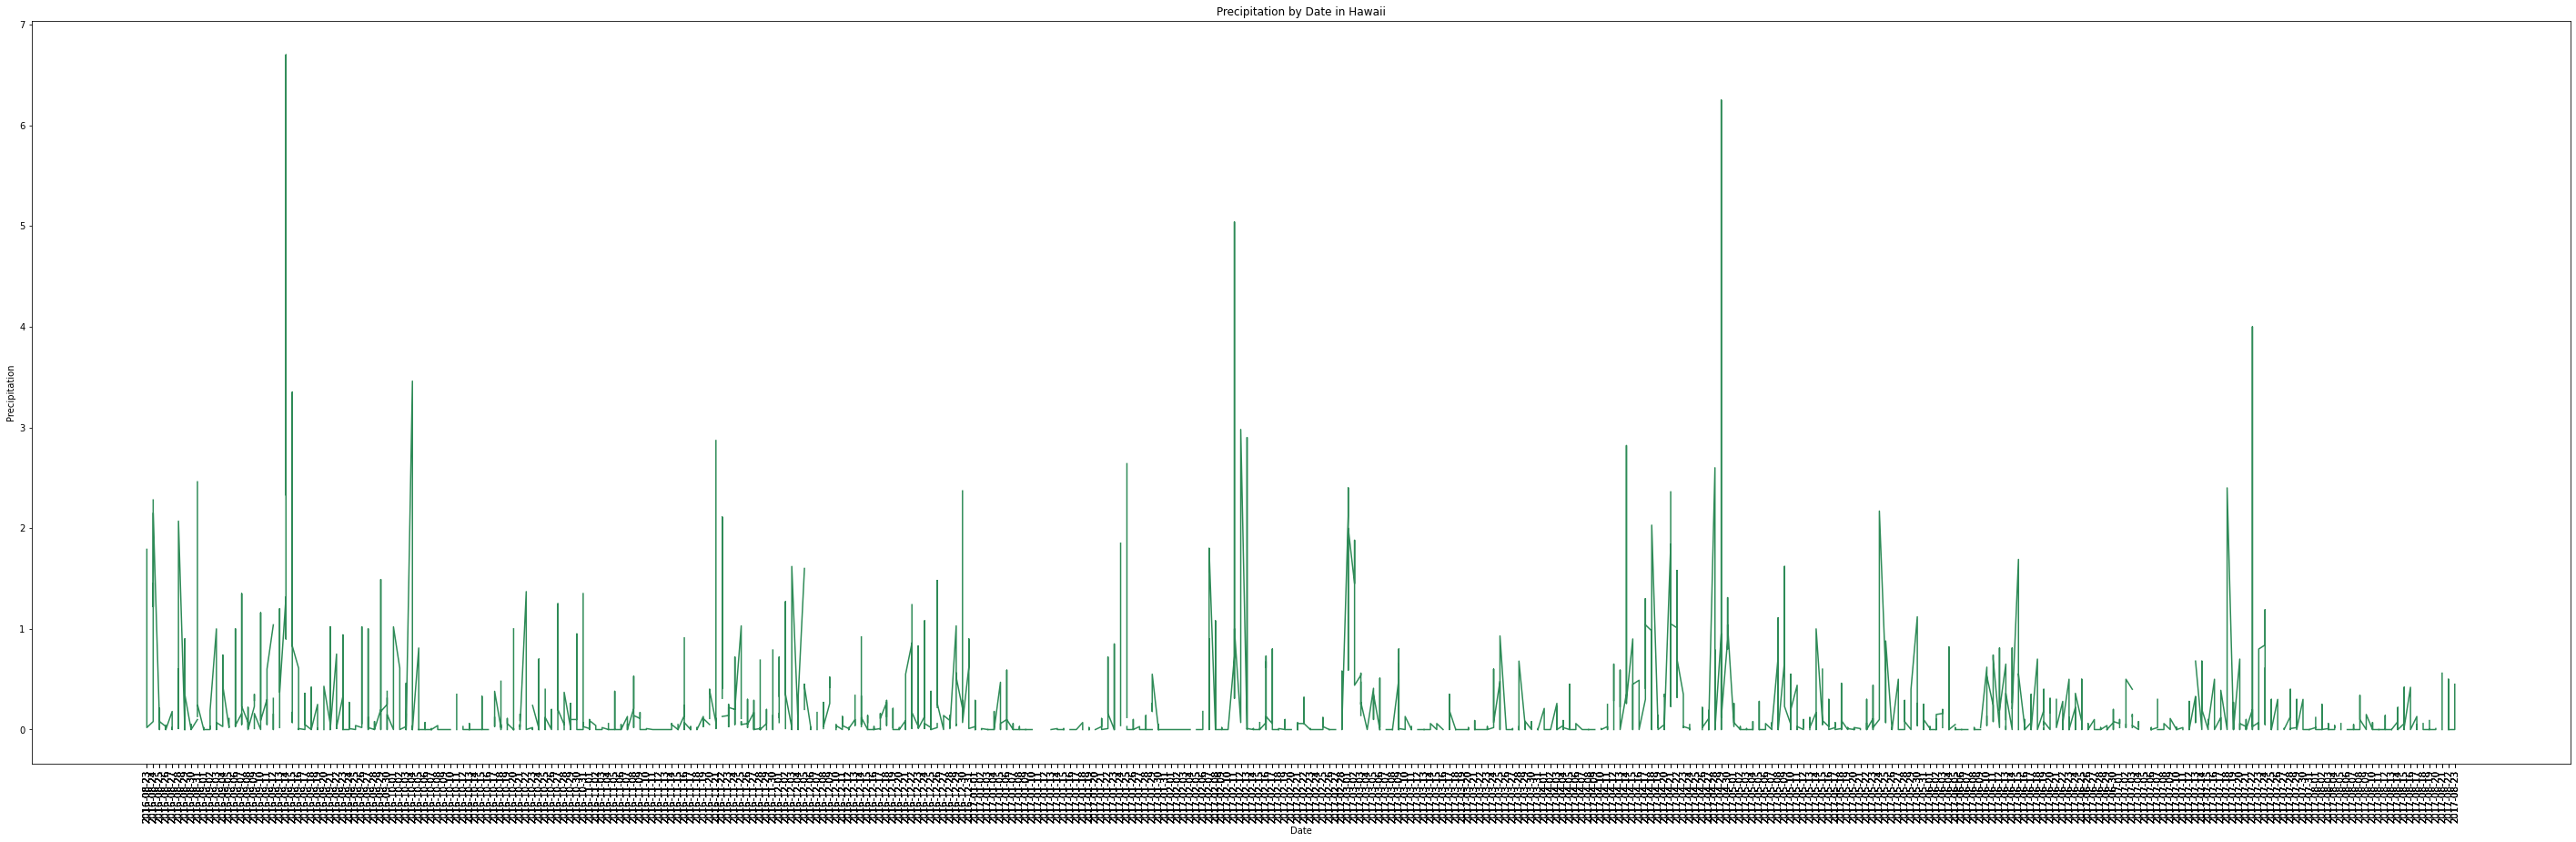

In [35]:
#Plot the results using the DataFrame plot method
plt.figure(figsize=(50,15))
plt.plot(df['date'], df['prcp'], color="seagreen")
plt.title("Precipitation by Date in Hawaii")
plt.xticks(df['date'], rotation=90, fontsize= 10)
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.show()

In [36]:
sum = df.groupby("date")["prcp"].sum()
avgs = df.groupby("date")["prcp"].mean()
med= df.groupby("date")["prcp"].median()
variance = df.groupby("date")["prcp"].var()
sdev= df.groupby("date")["prcp"].std()
sems= df.groupby("date")["prcp"].sem()

summ1 = pd.concat([sum, avgs, med, variance, sdev, sems], axis=1)
summ1.columns = ["Total", "Mean", "Median", "Variance", "Standard Deviation", "SEM"]
summ1

,Total,Mean,Median,Variance,Standard Deviation,SEM
date,,,,,,
2016-08-23,2.71,0.451667,0.100,0.499097,0.706468,0.288414
2016-08-24,9.33,1.555000,1.800,0.706510,0.840541,0.343150
2016-08-25,0.54,0.077143,0.080,0.005157,0.071813,0.027143
2016-08-26,0.10,0.016667,0.015,0.000267,0.016330,0.006667
2016-08-27,0.32,0.064000,0.020,0.006680,0.081731,0.036551
...,...,...,...,...,...,...
2017-08-19,0.09,0.030000,0.000,0.002700,0.051962,0.030000
2017-08-20,0.01,0.005000,0.005,0.000050,0.007071,0.005000
2017-08-21,0.58,0.193333,0.020,0.100933,0.317700,0.183424


Station Analysis

In [37]:
#Design a query to calculate the total number of stations in the dataset.
query= """
    SELECT
        *
    FROM
        station
    """
engine.execute(query).fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [38]:
#Design a query to find the most active stations (i.e. which stations have the most rows?)
#List the stations and observation counts in descending order
query= """
    SELECT
        s.station,
        count(*),
        s.name
    FROM
        station s
    JOIN 
        measurement m on s.station = m.station
    GROUP BY
        s.station
    ORDER BY
        s.station desc;
    """

engine.execute(query).fetchall()

[('USC00519523', 2669, 'WAIMANALO EXPERIMENTAL FARM, HI US'),
 ('USC00519397', 2724, 'WAIKIKI 717.2, HI US'),
 ('USC00519281', 2772, 'WAIHEE 837.5, HI US'),
 ('USC00518838', 511, 'UPPER WAHIAWA 874.3, HI US'),
 ('USC00517948', 1372, 'PEARL CITY, HI US'),
 ('USC00516128', 2612, 'MANOA LYON ARBO 785.2, HI US'),
 ('USC00514830', 2202, 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('USC00513117', 2709, 'KANEOHE 838.1, HI US'),
 ('USC00511918', 1979, 'HONOLULU OBSERVATORY 702.2, HI US')]

In [39]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
query= """
    SELECT
        min(m.tobs),
        max(m.tobs),
        avg(tobs)
    FROM
        station s
    JOIN 
        measurement m on s.station = m.station
    WHERE
        s.station = 'USC00519523';
    """

engine.execute(query).fetchall()

[(56.0, 85.0, 74.5436493068565)]

In [40]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query= """
    SELECT
        s.station,
        s.name,
        m.tobs,
        m.date
    FROM
        station s
    JOIN 
        measurement m on s.station = m.station
    WHERE
        s.station = 'USC00519523'
    AND
        date >= '2016-08-23';
    """
activestation_df = pd.read_sql(query, conn)

activestation_df.head()

,station,name,tobs,date
0,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",80.0,2016-08-23
1,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",79.0,2016-08-24
2,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",80.0,2016-08-25
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",84.0,2016-08-26
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",81.0,2016-08-27


Text(0.5, 1.0, 'Temperature by Date at Waimanalo Experimental Farm, Hawaii')

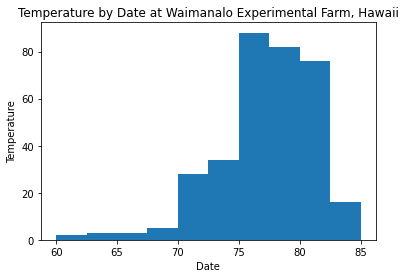

In [45]:
active_df = activestation_df.groupby(['date'])['tobs'].sum().reset_index()

active_df['tobs'].plot(kind='hist')
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("Temperature by Date at Waimanalo Experimental Farm, Hawaii")

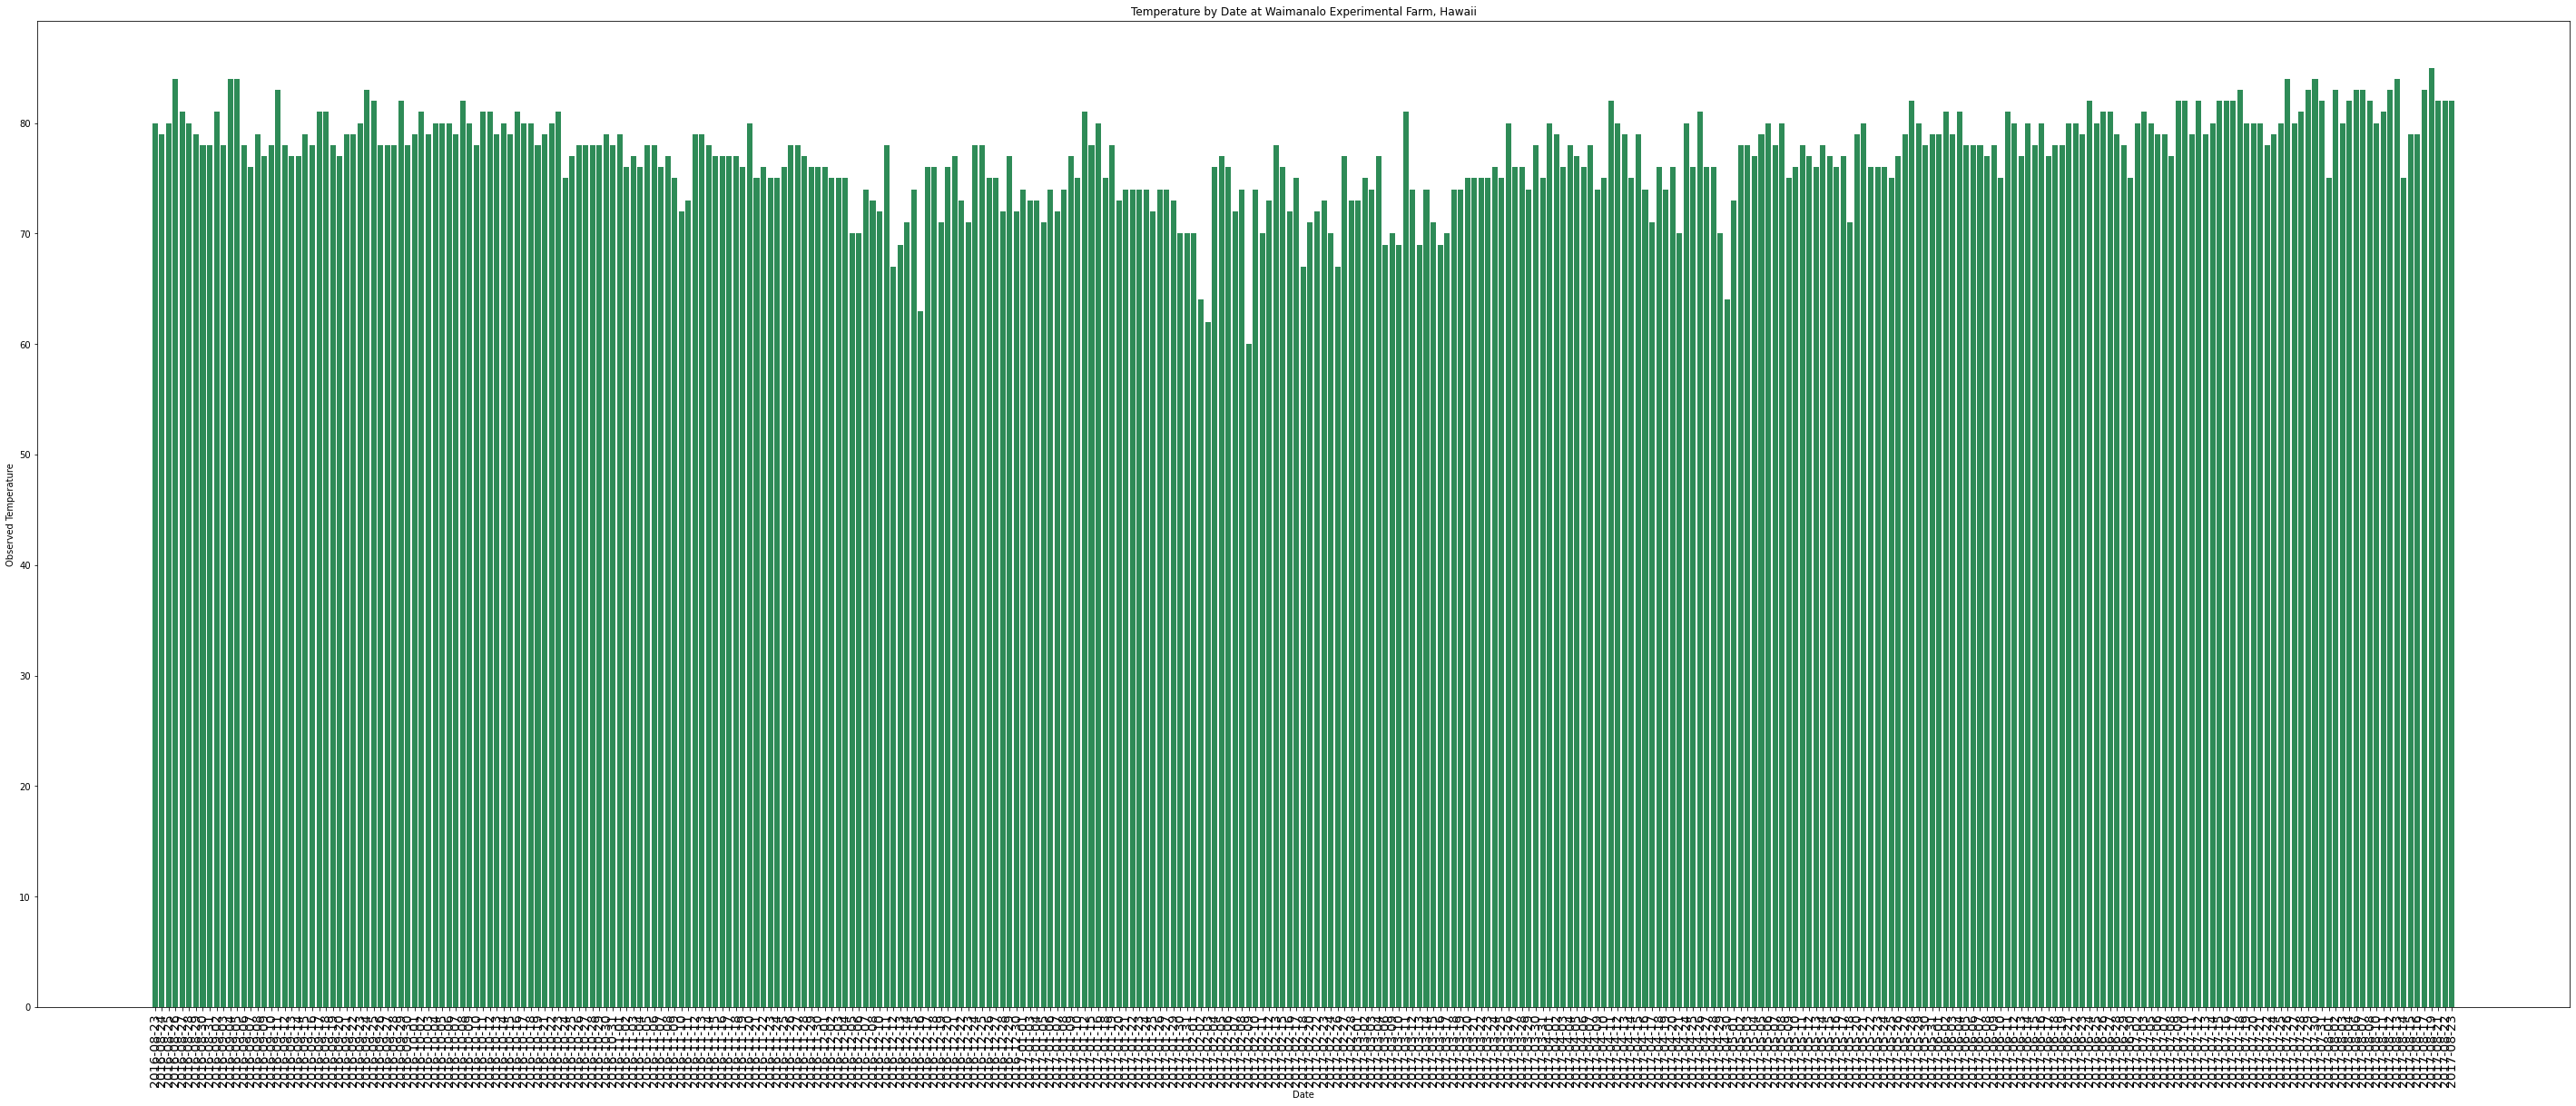

In [81]:
plt.figure(figsize=(50,20))
plt.bar(activestation_df['date'], activestation_df['tobs'], color= 'seagreen')
plt.title("Temperature by Date at Waimanalo Experimental Farm, Hawaii")
plt.xticks(activestation_df['date'], rotation=90, fontsize= 14)
plt.xlabel("Date")
plt.ylabel("Observed Temperature")
plt.show()

In [46]:
# Close Session
conn.close()

Climate App- Routes

In [ ]:
#design a Flask API based on the queries that you have just developed
#week 10 activity 3-10 database for reference- do queries here then use app.copy.py on activity in vscode
#See adams.py file

In [87]:
#/api/v1.0/precipitation
query= """
    SELECT
        date,
        station,
        prcp
    FROM
        measurement
    ORDER BY
        date asc,
        station asc
    """
df2= pd.read_sql(query, conn)
df2

,date,station,prcp
0,2010-01-01,USC00511918,0.05
1,2010-01-01,USC00513117,0.28
2,2010-01-01,USC00516128,0.14
3,2010-01-01,USC00518838,0.21
4,2010-01-01,USC00519281,0.15
...,...,...,...
19545,2017-08-22,USC00519523,0.00
19546,2017-08-23,USC00514830,0.00
19547,2017-08-23,USC00516128,0.45
19548,2017-08-23,USC00519397,0.00


In [8]:
#/api/v1.0/stations

query= """
    SELECT
        station,
        name
    FROM
        station
    """

df4= pd.read_sql(query, conn)
df4

,station,name
0,USC00519397,"WAIKIKI 717.2, HI US"
1,USC00513117,"KANEOHE 838.1, HI US"
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US"
3,USC00517948,"PEARL CITY, HI US"
4,USC00518838,"UPPER WAHIAWA 874.3, HI US"
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US"
6,USC00519281,"WAIHEE 837.5, HI US"
7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US"
8,USC00516128,"MANOA LYON ARBO 785.2, HI US"


In [9]:
#/api/v1.0/tobs

query="""
    SELECT
        s.station,
        s.name,
        m.tobs,
        m.date
    FROM
        station s
    JOIN 
        measurement m on s.station = m.station
    WHERE
        s.station = 'USC00519523'
    AND
        date >= '2016-08-23';
    """

df5= pd.read_sql(query, conn)
df5

,station,name,tobs,date
0,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",80.0,2016-08-23
1,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",79.0,2016-08-24
2,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",80.0,2016-08-25
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",84.0,2016-08-26
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",81.0,2016-08-27
...,...,...,...,...
332,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",83.0,2017-08-17
333,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",85.0,2017-08-19
334,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",82.0,2017-08-21
335,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",82.0,2017-08-22


In [20]:
#/api/v1.0/<start> 
startdate = "2016-01-01"

query= f"""
    SELECT
        min(tobs) as tmin,
        max(tobs) as tmax,
        avg(tobs) as tavg
    FROM
        measurement
    WHERE
        date = '{startdate}'
    """
df6= pd.read_sql(query, conn)
df6

,tmin,tmax,tavg
0,62.0,74.0,68.166667


In [21]:
#/api/v1.0/<start>/<end>
startdate = "2016-01-01"
enddate = "2016-08-01"

query= f"""
    SELECT
        min(tobs) as tmin,
        max(tobs) as tmax,
        avg(tobs) as tavg
    FROM
        measurement
    WHERE
        date >= '{startdate}'
    AND date <= '{enddate}'
    """

df7= pd.read_sql(query, conn)
df7

,tmin,tmax,tavg
0,56.0,83.0,72.985821
